# Denoising Autoencoder

Sticking with the MNIST dataset, let's add noise to our data and see if we can define and train an autoencoder to _de_-noise the images.

<img src='notebook_ims/autoencoder_denoise.png' width=70%/>

Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

Processing...
Done!


### Visualize the Data

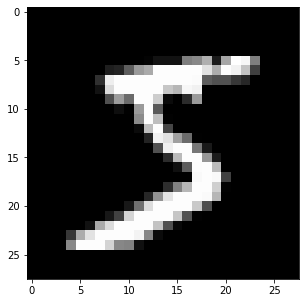

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1.

>**We'll use noisy images as input and the original, clean images as targets.** 

Below is an example of some of the noisy images I generated and the associated, denoised images.

<img src='notebook_ims/denoising.png' />


Since this is a harder problem for the network, we'll want to use _deeper_ convolutional layers here; layers with more feature maps. You might also consider adding additional layers. I suggest starting with a depth of 32 for the convolutional layers in the encoder, and the same depths going backward through the decoder.

#### TODO: Build the network for the denoising autoencoder. Add deeper and/or additional layers compared to the model above.

In [69]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        self.encoder_conv_layer_1 = nn.Conv2d(in_channels = 1,
                                              out_channels=16,
                                              kernel_size = 3,
                                              stride = 1,
                                              padding = 1)
        
        self.encoder_max_pool_layer2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.encoder_conv_layer_3 = nn.Conv2d(in_channels= 16,
                                              out_channels = 4,
                                              kernel_size = 3,
                                              stride = 1,
                                              padding = 1)
        
        self.encoder_max_pool_layer4 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
#         self.decoder_deconv_layer_5 = nn.ConvTranspose2d(in_channels= 4,
#                                                          out_channels = 4,
#                                                          kernel_size = 3,
#                                                          stride = 1,
#                                                          padding = 1)        
        
        
#         self.decoder_upsample_layer_6 = nn.Upsample(scale_factor=2, mode='nearest')
        
        self.decoder_conv_layer_7 = nn.ConvTranspose2d(in_channels= 4,
                                                       out_channels = 16,
                                                       kernel_size = 2,
                                                       stride = 2,
                                                       padding = 0)
        
        self.decoder_upsample_layer_8 = nn.Upsample(scale_factor=2, mode='nearest')
        
        
        self.decoder_conv_layer_9 = nn.ConvTranspose2d(in_channels= 16,
                                                       out_channels = 1,
                                                       kernel_size = 3,
                                                       stride = 1,
                                                       padding = 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        ## encode ##
        #print(x.shape)
        x = self.encoder_conv_layer_1(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.encoder_max_pool_layer2(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.encoder_conv_layer_3(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.encoder_max_pool_layer4(x)
        x = self.relu(x)
        #print(x.shape)
#         x = self.decoder_deconv_layer_5(x)
#         x = self.relu(x)
        #print(x.shape)
        
#         x = self.decoder_upsample_layer_6(x)
        #print(x.shape)
        x = self.decoder_conv_layer_7(x)
        x = self.relu(x)
        # print(x.shape)
        x = self.decoder_upsample_layer_8(x)
        # print(x.shape)        
        x = self.decoder_conv_layer_9(x)
        x = self.sigmoid(x)
        # print(x.shape)
        
        return x


# initialize the NN
model = ConvDenoiser().cuda()
print(model)

ConvDenoiser(
  (encoder_conv_layer_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_max_pool_layer2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder_conv_layer_3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_max_pool_layer4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (decoder_conv_layer_7): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (decoder_upsample_layer_8): Upsample(scale_factor=2, mode=nearest)
  (decoder_conv_layer_9): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [68]:
x = torch.randint(1, size = (16, 1, 28, 28) ).type('torch.FloatTensor').cuda()
model(x)

torch.Size([16, 16, 14, 14])
torch.Size([16, 16, 28, 28])
torch.Size([16, 1, 28, 28])


tensor([[[[0.4554, 0.4555, 0.4573,  ..., 0.4568, 0.4580, 0.4631],
          [0.4401, 0.4429, 0.4501,  ..., 0.4427, 0.4495, 0.4537],
          [0.4394, 0.4426, 0.4481,  ..., 0.4414, 0.4470, 0.4491],
          ...,
          [0.4394, 0.4424, 0.4493,  ..., 0.4424, 0.4499, 0.4539],
          [0.4388, 0.4428, 0.4481,  ..., 0.4419, 0.4482, 0.4504],
          [0.4431, 0.4427, 0.4403,  ..., 0.4430, 0.4409, 0.4456]]],


        [[[0.4554, 0.4555, 0.4573,  ..., 0.4568, 0.4580, 0.4631],
          [0.4401, 0.4429, 0.4501,  ..., 0.4427, 0.4495, 0.4537],
          [0.4394, 0.4426, 0.4481,  ..., 0.4414, 0.4470, 0.4491],
          ...,
          [0.4394, 0.4424, 0.4493,  ..., 0.4424, 0.4499, 0.4539],
          [0.4388, 0.4428, 0.4481,  ..., 0.4419, 0.4482, 0.4504],
          [0.4431, 0.4427, 0.4403,  ..., 0.4430, 0.4409, 0.4456]]],


        [[[0.4554, 0.4555, 0.4573,  ..., 0.4568, 0.4580, 0.4631],
          [0.4401, 0.4429, 0.4501,  ..., 0.4427, 0.4495, 0.4537],
          [0.4394, 0.4426, 0.4481,  ..

---
## Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [70]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [71]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        
        ## add random noise to the input images
        noisy_imgs = images + (noise_factor * torch.randn(*images.shape))
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        noisy_imgs = noisy_imgs.cuda()
        images = images.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.572812
Epoch: 2 	Training Loss: 0.402151
Epoch: 3 	Training Loss: 0.390083
Epoch: 4 	Training Loss: 0.383985
Epoch: 5 	Training Loss: 0.380774
Epoch: 6 	Training Loss: 0.378404
Epoch: 7 	Training Loss: 0.376287
Epoch: 8 	Training Loss: 0.374704
Epoch: 9 	Training Loss: 0.372945
Epoch: 10 	Training Loss: 0.371726
Epoch: 11 	Training Loss: 0.370561
Epoch: 12 	Training Loss: 0.369331
Epoch: 13 	Training Loss: 0.368059
Epoch: 14 	Training Loss: 0.366610
Epoch: 15 	Training Loss: 0.366765
Epoch: 16 	Training Loss: 0.365466
Epoch: 17 	Training Loss: 0.364927
Epoch: 18 	Training Loss: 0.364395
Epoch: 19 	Training Loss: 0.363487
Epoch: 20 	Training Loss: 0.362493


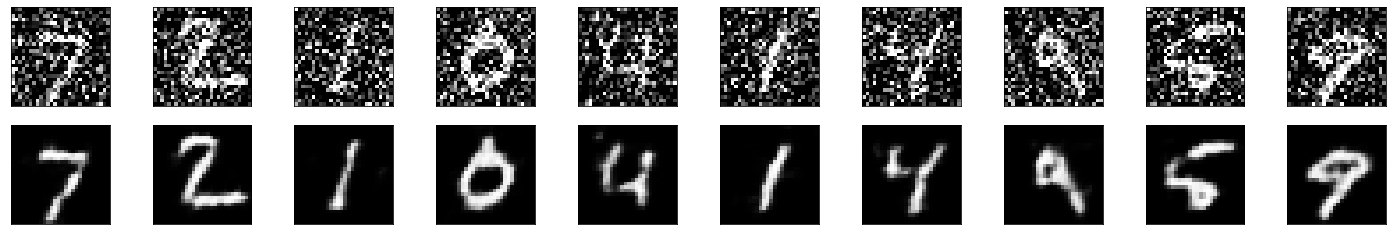

In [72]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs.cuda())
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.cpu().view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.